# Part 3

9. **Build model**
   - transfer learning

10. **Evaluate**
    1. classification report text file 로 저장하는 module 생성
    2. recall 값과 f1 값

##Trial_1_ResNet34

accuracy : 50%

In [ ]:
# ResNet34 block
def build_resnet_block_34(input_layer, num_cnn, channel, block_num, unit_one=False):

  x = input_layer
  

  for cnn_num in range(num_cnn):

            skip = x

            if not unit_one and cnn_num == 0: #첫번쨰 유닛이 아니고 첫번째 레이어일 때 stride=2 추가
              
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides = 2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_first_conv{cnn_num}'
                )(x)

            else:
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
                )(x)

            
            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_1_bn_{cnn_num}')(x)


            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_activtion_{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_2_conv{cnn_num}'
            )(x)

            if not unit_one: #첫번째 유닛이 아니고 첫번째 레이어일 때 skip레이어 추가
              if cnn_num == 0:

                skip = keras.layers.Conv2D(
                 filters=channel,
                 kernel_size=(1,1),
                 strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name=f'block{block_num}_skip_conv{cnn_num}'
                 )(skip)


            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_2_bn_{cnn_num}')(x)


            if not unit_one: #첫번째 유닛이 아니고 첫번째 레이어일 때 batchnorm 추가
              if cnn_num == 0:
                skip = keras.layers.BatchNormalization(
                  name=f'block{block_num}_skip_bn_{cnn_num}')(skip)


            x = keras.layers.Add()([x,skip])

            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_1_activtion_{cnn_num}')(x)

  return x



In [ ]:
def resnet_34(input_shape=(128,219,1),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=4):

  input_layer = keras.layers.Input(shape=input_shape) #input layer 만들기
  output = input_layer

  output = keras.layers.Conv2D(
                 filters=64,
                 kernel_size=(7,7),
                 strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name='block_0_conv'
              )(output)

  output = keras.layers.BatchNormalization(
                name='block_0_bn')(output)

  output = keras.layers.Activation(
                'relu', name = 'block_0_activtion')(output)

  output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2, name = 'MaxPooling')(output)
    

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)): #첫번째 유닛일 때 unit_one = True
    if i == 0:
      output = build_resnet_block_34(output, num_cnn=num_cnn, channel=channel, block_num=i, unit_one = True)
    else:
      output = build_resnet_block_34(output, num_cnn=num_cnn, channel=channel, block_num=i)


  output = keras.layers.AveragePooling2D(pool_size = (1,1),
                                      name = 'last_AveragePooling')(output)

  output = keras.layers.Flatten(name = 'Flatten')(output)
  
  output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

  model = keras.Model(inputs=input_layer, outputs=output)

  return model

In [ ]:
resnet_34 = resnet_34()
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 219, 1  0           []                               
                                )]                                                                
                                                                                                  
 block_0_conv (Conv2D)          (None, 64, 110, 64)  3200        ['input_1[0][0]']                
                                                                                                  
 block_0_bn (BatchNormalization  (None, 64, 110, 64)  256        ['block_0_conv[0][0]']           
 )                                                                                                
                                                                                              

In [ ]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
resnet_34.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(resnet_34.optimizer.learning_rate, 0.001)

In [ ]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/resnet-003.h5'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줍니다
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [ ]:
history=resnet_34.fit(
    x_train_1,
    y_train_1,
    batch_size = 64,
    validation_data=(x_test_1,y_test_1),
    epochs=200,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/200
161/161 [==============================] - 46s 154ms/step - loss: 5.5109 - sparse_categorical_accuracy: 0.2617 - val_loss: 1.3873 - val_sparse_categorical_accuracy: 0.2703 - lr: 0.0010
Epoch 2/200
161/161 [==============================] - 25s 154ms/step - loss: 3.9619 - sparse_categorical_accuracy: 0.2868 - val_loss: 1.3544 - val_sparse_categorical_accuracy: 0.3337 - lr: 0.0010
Epoch 3/200
161/161 [==============================] - 21s 130ms/step - loss: 3.2457 - sparse_categorical_accuracy: 0.3005 - val_loss: 1.9637 - val_sparse_categorical_accuracy: 0.0891 - lr: 0.0010
Epoch 4/200
161/161 [==============================] - 21s 130ms/step - loss: 2.9791 - sparse_categorical_accuracy: 0.3136 - val_loss: 2.1324 - val_sparse_categorical_accuracy: 0.4873 - lr: 0.0010
Epoch 5/200
161/161 [==============================] - 21s 129ms/step - loss: 2.4216 - sparse_categorical_accuracy: 0.3323 - val_loss: 1.5711 - val_sparse_categorical_accuracy: 0.5109 - lr: 0.0010
Epoch 6/200
161

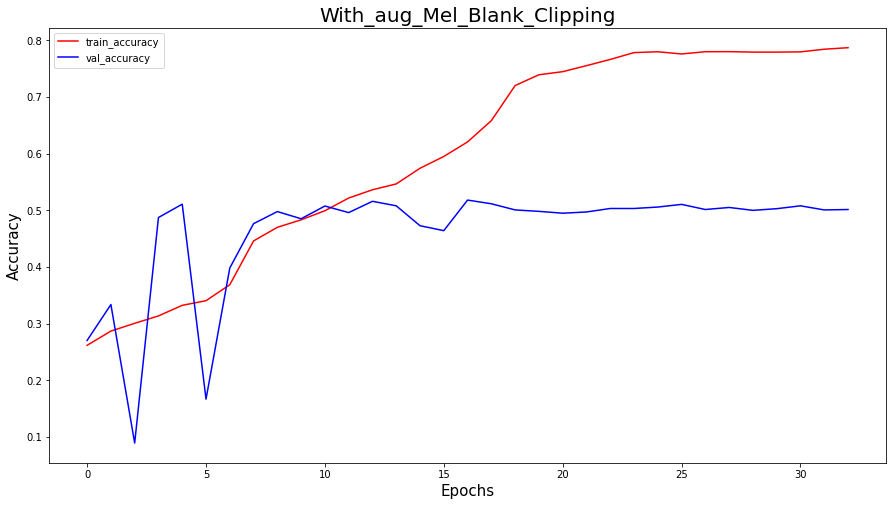

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history.history['sparse_categorical_accuracy'], label = 'train_accuracy', linestyle='solid', color='r')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy', linestyle='solid', color='b')

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.title('With_aug_Mel_Blank_Clipping', fontsize = 20)
plt.show()

classification report

In [ ]:
y_pred = resnet_34.predict(x_test_1)

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(np.argmax(y_pred, axis = 1), y_test_1)

array([[945, 329, 139,  83],
       [312, 313,  87,  65],
       [135,  51,  89,  17],
       [ 65,  53,  40,  37]])

In [ ]:
from sklearn.metrics import classification_report

target_names=['Normal', 'Crackle', 'Wheeze', 'Both']

clf_report = classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names, output_dict=True)
print(classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.63      0.65      0.64      1457
     Crackle       0.40      0.42      0.41       746
      Wheeze       0.30      0.25      0.28       355
        Both       0.19      0.18      0.19       202

    accuracy                           0.50      2760
   macro avg       0.38      0.38      0.38      2760
weighted avg       0.50      0.50      0.50      2760



##trial_2_simple cnn + one skip connection

accuracy : 59%


In [ ]:
mSpec_input=keras.layers.Input(shape=(128,219,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

skip_x = x
skip_x = keras.layers.Conv2D(96,3,strides=(2,4),padding='same')(skip_x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x = keras.layers.Add()([x,skip_x])
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.GlobalMaxPooling2D()(x)

x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(50,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(25,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
output=keras.layers.Dense(4,activation='softmax')(x)


mSpec_model=keras.Model(mSpec_input, output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mSpecInput (InputLayer)        [(None, 128, 219, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 73, 32)   832         ['mSpecInput[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 73, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                         

In [ ]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
mSpec_model.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model.optimizer.learning_rate, 0.001)

In [ ]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/mSpec_model-001.h5'
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [ ]:
history_2 = mSpec_model.fit(
    x_train_1,
    y_train_1,
    batch_size = 16,
    validation_data=(x_test_1,y_test_1),
    epochs=200,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/200
642/642 [==============================] - 9s 11ms/step - loss: 1.4168 - sparse_categorical_accuracy: 0.2705 - val_loss: 1.4161 - val_sparse_categorical_accuracy: 0.0732 - lr: 0.0010
Epoch 2/200
642/642 [==============================] - 6s 10ms/step - loss: 1.3773 - sparse_categorical_accuracy: 0.2940 - val_loss: 1.4092 - val_sparse_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/200
642/642 [==============================] - 6s 9ms/step - loss: 1.3503 - sparse_categorical_accuracy: 0.3221 - val_loss: 1.2663 - val_sparse_categorical_accuracy: 0.5286 - lr: 0.0010
Epoch 4/200
642/642 [==============================] - 6s 10ms/step - loss: 1.3290 - sparse_categorical_accuracy: 0.3386 - val_loss: 1.1952 - val_sparse_categorical_accuracy: 0.5243 - lr: 0.0010
Epoch 5/200
642/642 [==============================] - 7s 11ms/step - loss: 1.3118 - sparse_categorical_accuracy: 0.3502 - val_loss: 1.2665 - val_sparse_categorical_accuracy: 0.4909 - lr: 0.0010
Epoch 6/200
642/642 [=====

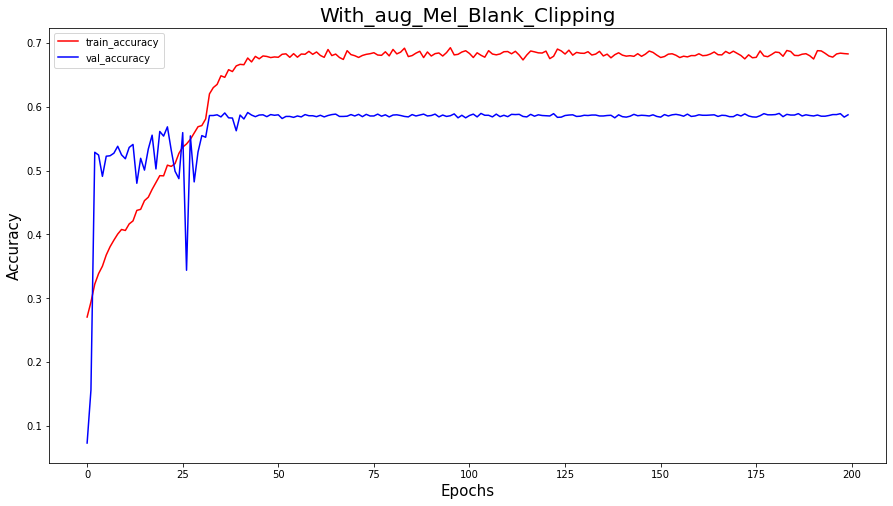

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history_2.history['sparse_categorical_accuracy'], label = 'train_accuracy', linestyle='solid', color='r')
plt.plot(history_2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy', linestyle='solid', color='b')

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.title('With_aug_Mel_Blank_Clipping', fontsize = 20)
plt.show()

In [ ]:
y_pred = mSpec_model.predict(x_test_1)

In [ ]:
clf_report = classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names, output_dict=True)
print(classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.68      0.73      0.71      1457
     Crackle       0.47      0.48      0.47       746
      Wheeze       0.52      0.38      0.44       355
        Both       0.36      0.32      0.34       202

    accuracy                           0.59      2760
   macro avg       0.51      0.48      0.49      2760
weighted avg       0.58      0.59      0.58      2760



In [ ]:
with open( root+ "clf_report_resnet34_1.txt", "w") as text_file:
    print(classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names), file=text_file)